# Crop Yield Prediction: PyTorch 1D-CNN

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

# Optuna Visualization Tools
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/Users/pavin/Documents/GitHub/ML_project/Final/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### 1. Data Preparation and Crop Choice
We load the main dataset and identify the available crops. For this analysis, we focus specifically on **Rice**. We clean the data by removing columns related to other crops and deleting any rows where the target yield information is missing.

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_v3.parquet')

# --- LIST AVAILABLE CROPS ---
# Assumes targets start with 'Y_'
target_columns = [col for col in df.columns if col.startswith('Y_')]
available_crops = [col.replace('Y_', '') for col in target_columns]

print("--- Available Crops found in Dataset ---")
print(available_crops)
print("-" * 40)

# --- CONFIGURATION: SET CROP HERE ---
CHOSEN_CROP = 'rice'  # <--- CHANGE THIS to 'lettuce', 'pepper', etc. based on list above
# ------------------------------------

# Define Target and Dynamic Lag Features
TARGET_COL = f'Y_{CHOSEN_CROP}'
LAG_1_FEATURE = f'avg_yield_{CHOSEN_CROP}_1y'

if TARGET_COL not in df.columns:
    raise ValueError(f"Target {TARGET_COL} not found in dataset. Check spelling.")

print(f"Predicting Target: {TARGET_COL}")
print(f"Using Lag 1 Feature: {LAG_1_FEATURE}")

# Clean Missing Targets for the chosen crop
df_model = df.dropna(subset=[TARGET_COL])

print(f"Data Loaded. Rows with valid target: {len(df_model)}")

--- Available Crops found in Dataset ---
['bananas', 'barley', 'cassava_fresh', 'cucumbers_and_gherkins', 'maize_corn', 'oil_palm_fruit', 'other_vegetables_fresh_nec', 'potatoes', 'rice', 'soya_beans', 'sugar_beet', 'sugar_cane', 'tomatoes', 'watermelons', 'wheat']
----------------------------------------
Predicting Target: Y_rice
Using Lag 1 Feature: avg_yield_rice_1y
Data Loaded. Rows with valid target: 4687


### 2. Selecting Features, Splitting, and Scaling Data
We identify the input variables. We split data by year to avoid data leakage. **Crucially**, for Neural Networks, we must scale the data (StandardScaler) so that all features have a mean of 0 and variance of 1, preventing gradient instability.

**1D-CNN Note:** While we are treating tabular data, we will reshape the tensors later to be `[Batch_Size, Channels, Length]`. Here, we treat each feature as a "time-step" or sequence element with 1 channel, or more commonly for tabular CNNs, treat the row as `[Batch, 1, Features]`.

In [3]:
# --- IMPORTS (Add these if not already present) ---
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import torch
import pandas as pd


# --- Remove min/max outliers per country ---
df_model = df_model.copy()

# Find indices for min and max yields
idx_min = df_model.groupby('area')[TARGET_COL].idxmin().values
idx_max = df_model.groupby('area')[TARGET_COL].idxmax().values

# Combine them
rows_to_drop = np.concatenate([idx_min, idx_max])

# Drop them
df_model = df_model.iloc[~df_model.index.isin(rows_to_drop)].reset_index(drop=True)
print(f"Data count after cleaning outliers: {len(df_model)}")


# --- DROP UNWANTED COLUMNS ---
# Drop all columns that start with "avg_yield_" but do NOT match the chosen crop
cols_to_drop = [c for c in df_model.columns 
                if c.startswith("avg_yield_") and CHOSEN_CROP not in c]

df_model = df_model.drop(columns=cols_to_drop)

# --- FEATURE SELECTION ---
# Select independent variables (exclude 'Y_' columns and metadata)
feature_cols = [c for c in df_model.columns 
                if not c.startswith('Y_') and c not in ['area']]

# --- DISPLAY FEATURES TABLE ---
print(f"Total Features Used: {len(feature_cols)}")
print("-" * 30)
feature_preview = pd.DataFrame(feature_cols, columns=['Feature Name']).T
display(feature_preview)

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2014
VAL_END_YEAR = 2019

# 1. Training Set (< 2014)
mask_train = df_model['year'] < TRAIN_END_YEAR
X_train_raw = df_model[mask_train][feature_cols]
y_train = df_model[mask_train][TARGET_COL]

# 2. Validation Set (>= 2014 and < 2019)
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
X_val_raw = df_model[mask_val][feature_cols]
y_val = df_model[mask_val][TARGET_COL]

# 3. Test Set (>= 2019)
mask_test = df_model['year'] >= VAL_END_YEAR
X_test_raw = df_model[mask_test][feature_cols]
y_test = df_model[mask_test][TARGET_COL]

# --- IMPUTATION (Handle NaNs before scaling) ---
imputer = SimpleImputer(strategy='mean')  # Or 'median' if data is skewed
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=feature_cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_raw), columns=feature_cols)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_raw), columns=feature_cols)

# Optional: Print NaN counts to verify (should be 0 after imputation)
print("NaNs in X_train_imputed:", X_train_imputed.isnull().sum().sum())
print("NaNs in X_val_imputed:", X_val_imputed.isnull().sum().sum())
print("NaNs in X_test_imputed:", X_test_imputed.isnull().sum().sum())

# --- SCALING (Required for Neural Networks) ---
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_imputed)
X_val = scaler.transform(X_val_imputed)
X_test = scaler.transform(X_test_imputed)

# --- RESHAPE FOR 1D CNN ---
# PyTorch Conv1d expects input shape: (Batch Size, Channels, Sequence Length)
# For tabular data, we usually treat 'Channels' as 1 and 'Sequence Length' as number of features.
X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val_cnn = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_cnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Convert to PyTorch Tensors
X_train_tensor = torch.tensor(X_train_cnn, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val_cnn, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_cnn, dtype=torch.float32).to(device)

print(f"\nTraining Samples   (<{TRAIN_END_YEAR})     : {len(X_train)}")
print(f"Validation Samples ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1}): {len(X_val)}")
print(f"Testing Samples    (>={VAL_END_YEAR})    : {len(X_test)}")
print(f"CNN Input Shape (Batch, Channels, Features): {X_train_tensor.shape}")

Data count after cleaning outliers: 4441
Total Features Used: 17
------------------------------


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Feature Name,year,avg_yield_rice_1y,avg_yield_rice_2y,avg_yield_rice_3y,rain_annual,rain_sin,rain_cos,solar_annual,solar_sin,solar_cos,temp_annual,temp_sin,temp_cos,pesticides_lag1,fertilizer_lag1,latitude,longitude


NaNs in X_train_imputed: 0
NaNs in X_val_imputed: 0
NaNs in X_test_imputed: 0

Training Samples   (<2014)     : 3383
Validation Samples (2014-2018): 541
Testing Samples    (>=2019)    : 517
CNN Input Shape (Batch, Channels, Features): torch.Size([3383, 1, 17])


### 4. Initial Model Testing
We train a basic **1D-CNN** model using standard settings. We plot the training vs validation loss to check for overfitting or underfitting. The architecture involves a convolutional layer, pooling, flattening, and dense layers.

Epoch 0/150 | Train RMSE: 3809.23 | Val RMSE: 4503.94
Epoch 20/150 | Train RMSE: 690.72 | Val RMSE: 809.70
Epoch 40/150 | Train RMSE: 558.58 | Val RMSE: 568.59
Epoch 60/150 | Train RMSE: 533.72 | Val RMSE: 524.99
Epoch 80/150 | Train RMSE: 524.27 | Val RMSE: 493.04
Epoch 100/150 | Train RMSE: 522.56 | Val RMSE: 507.01
Epoch 120/150 | Train RMSE: 515.94 | Val RMSE: 476.46
Epoch 140/150 | Train RMSE: 517.32 | Val RMSE: 461.14
Epoch 149/150 | Train RMSE: 515.73 | Val RMSE: 467.22


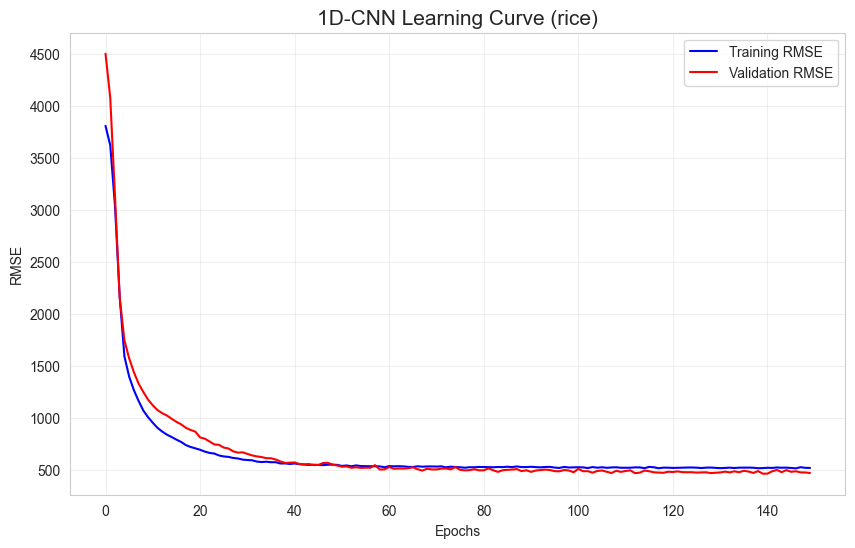

Metric      Train  Validation     Test 0
  RMSE 482.542938  467.223631 484.143549
    R²   0.931194    0.953789   0.949911


In [4]:
# --- DEFINE 1D-CNN STRUCTURE ---
class SimpleCNN1D(nn.Module):
    def __init__(self, input_len):
        super(SimpleCNN1D, self).__init__()
        # Conv1d: in_channels=1 (tabular row), out_channels=32 filters
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        
        # Calculate size after pooling for the linear layer
        conv_out_size = input_len // 2 * 32
        
        self.fc1 = nn.Linear(conv_out_size, 32)
        self.fc2 = nn.Linear(32, 1)
        
    def forward(self, x):
        # x shape: [batch, 1, features]
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# --- TRAINING HELPER FUNCTION ---
def train_model_init(model_init, X_t, y_t, X_v, y_v, lr=0.001, epochs=150, batch_size=32, verbose=True):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_init.parameters(), lr=lr)
    
    train_loader = DataLoader(TensorDataset(X_t, y_t), batch_size=batch_size, shuffle=True)
    
    train_losses_init = []
    val_losses_init = []
    
    for epoch in range(epochs):
        model_init.train()
        epoch_loss = 0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model_init(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)
            
        train_mse = epoch_loss / len(X_t)
        train_rmse = np.sqrt(train_mse)
        
        model_init.eval()
        with torch.no_grad():
            val_outputs = model_init(X_v)
            val_loss = criterion(val_outputs, y_v)
            val_rmse = np.sqrt(val_loss.item())
            
        train_losses_init.append(train_rmse)
        val_losses_init.append(val_rmse)
        
        if verbose and (epoch % 20 == 0 or epoch == epochs-1):
            print(f"Epoch {epoch}/{epochs} | Train RMSE: {train_rmse:.2f} | Val RMSE: {val_rmse:.2f}")
            
    return train_losses_init, val_losses_init

# --- INITIAL MODEL TRAINING ---
input_features_init = X_train_tensor.shape[2]  # Sequence length / num features
model_init = SimpleCNN1D(input_features_init).to(device)

train_hist_init, val_hist_init = train_model_init(
    model_init, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor
)

# --- PLOT LEARNING CURVE ---
plt.figure(figsize=(10, 6))
plt.plot(train_hist_init, label='Training RMSE', color='blue')
plt.plot(val_hist_init, label='Validation RMSE', color='red')
plt.title(f'1D-CNN Learning Curve ({CHOSEN_CROP})', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- Predict on Train, Validation, and Test sets ---
model_init.eval()
with torch.no_grad():
    y_pred_train_init = model_init(X_train_tensor).cpu().numpy().flatten()
    y_pred_val_init = model_init(X_val_tensor).cpu().numpy().flatten()
    y_pred_test_init = model_init(X_test_tensor).cpu().numpy().flatten()

# --- Compute Metrics ---
rmse_train_init = np.sqrt(mean_squared_error(y_train, y_pred_train_init))
rmse_val_init = np.sqrt(mean_squared_error(y_val, y_pred_val_init))
rmse_test_init = np.sqrt(mean_squared_error(y_test, y_pred_test_init))

r2_train_init = r2_score(y_train, y_pred_train_init)
r2_val_init = r2_score(y_val, y_pred_val_init)
r2_test_init = r2_score(y_test, y_pred_test_init)

# --- Prepare Summary Table ---
metrics_df_init = pd.DataFrame({
    'Metric': ['RMSE', 'R²'],
    'Train': [rmse_train_init, r2_train_init],
    'Validation': [rmse_val_init, r2_val_init],
    'Test 0': [rmse_test_init, r2_test_init]
})

# --- Display Table ---
print(metrics_df_init.to_string(index=False))


### 5. Tuning the Model (Optuna)
To improve performance, we use **Optuna** to find the best CNN architecture. We run trials adjusting the number of filters, kernel sizes, dropout rate, learning rate, and batch size.

In [5]:
# --- DYNAMIC 1D-CNN BUILDER ---
class DynamicCNN1D(nn.Module):
    def __init__(self, input_len, n_filters, kernel_size, dropout, activation_name):
        super(DynamicCNN1D, self).__init__()
        
        # Choose Activation Function
        if activation_name == "ReLU":
            self.activation = nn.ReLU()
        elif activation_name == "LeakyReLU":
            self.activation = nn.LeakyReLU()
        else:
            self.activation = nn.Tanh()

        # Convolutional Block
        # padding = kernel_size // 2 maintains roughly same size before pooling
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_filters, 
                               kernel_size=kernel_size, padding=kernel_size//2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout_layer = nn.Dropout(dropout)
        
        # Calculate Flatten Size
        # Output length after MaxPool1d(2) is floor(input_len / 2)
        # We must handle cases where input_len < 2 properly, though tabular usually > 20
        feature_map_len = input_len // 2
        flat_dim = feature_map_len * n_filters
        
        # Dense Layers
        self.fc1 = nn.Linear(flat_dim, n_filters)
        self.fc2 = nn.Linear(n_filters, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activation(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout_layer(x)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# --- OPTUNA OBJECTIVE FUNCTION ---
def objective(trial):
    # 1. Suggest Hyperparameters
    n_filters = trial.suggest_int("n_filters", 16, 128, step=16)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7])
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64])  # Larger batches stable
    activation = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])  # Drop Tanh
    optimizer_name = "Adam"  # Fixed to Adam; comment out if testing SGD

    # 2. Build Model
    # input_features taken from X_train_tensor.shape[2]
    input_features = X_train_tensor.shape[2]
    model = DynamicCNN1D(input_features, n_filters, kernel_size, dropout, activation).to(device)
    
    # 3. Setup Training
    criterion = nn.MSELoss()
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), 
                              batch_size=batch_size, shuffle=True)
    
    # 4. Training Loop with Pruning
    epochs = 50  # Reduced slightly for speed during tuning
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate on Validation
        model.eval()
        with torch.no_grad():
            val_pred = model(X_val_tensor)
            val_mse = criterion(val_pred, y_val_tensor).item()
            val_rmse = np.sqrt(val_mse)

        # Pruning check
        trial.report(val_rmse, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_rmse

# --- RUN OPTIMIZATION ---
study_name = f'{CHOSEN_CROP.capitalize()}_Yield_CNN'
study = optuna.create_study(direction='minimize', study_name=study_name)
study.optimize(objective, n_trials=20)

print("\nBest Parameters found:")
print(study.best_params)

[I 2025-12-09 14:19:33,386] A new study created in memory with name: Rice_Yield_CNN
[I 2025-12-09 14:19:40,031] Trial 0 finished with value: 615.3248379920966 and parameters: {'n_filters': 32, 'kernel_size': 7, 'dropout': 0.2933712478615628, 'lr': 0.0011511410593483531, 'batch_size': 64, 'activation': 'ReLU'}. Best is trial 0 with value: 615.3248379920966.
[I 2025-12-09 14:19:51,219] Trial 1 finished with value: 546.1002655190712 and parameters: {'n_filters': 128, 'kernel_size': 3, 'dropout': 0.3687016814676922, 'lr': 0.0004616684793636306, 'batch_size': 32, 'activation': 'LeakyReLU'}. Best is trial 1 with value: 546.1002655190712.
[I 2025-12-09 14:19:59,902] Trial 2 finished with value: 672.3652513701165 and parameters: {'n_filters': 80, 'kernel_size': 5, 'dropout': 0.11004068278471829, 'lr': 0.00026604760542577066, 'batch_size': 32, 'activation': 'ReLU'}. Best is trial 1 with value: 546.1002655190712.
[I 2025-12-09 14:20:06,824] Trial 3 finished with value: 1273.0416823497965 and par


Best Parameters found:
{'n_filters': 128, 'kernel_size': 5, 'dropout': 0.2919274803213698, 'lr': 0.00938599379698373, 'batch_size': 32, 'activation': 'LeakyReLU'}


### 6. Visualizing Optimization
We generate charts to understand the tuning process. These visual tools show us which specific settings (like kernel size or number of filters) had the biggest impact on reducing the model's error.

In [6]:
# --- OPTUNA VISUALIZATIONS ---
name = f"{CHOSEN_CROP.capitalize()}_Yield_CNN"

# 1. Optimization History
fig = plot_optimization_history(study)
fig.update_layout(title=f'{name} Optimization History', width=900, height=500)
fig.show()

# 2. Parallel Coordinate (Hyperparameter Relationships)
fig = plot_parallel_coordinate(study)
fig.update_layout(title=f'{name} Parallel Coordinate Plot', width=900, height=500)
fig.show()

# 3. Slice Plot (Individual Parameter impact)
fig = plot_slice(study)
fig.update_layout(title=f'{name} Slice Plot', width=900, height=500)
fig.show()

# 4. Parameter Importance
try:
    fig = plot_param_importances(study)
    fig.update_layout(title=f'{name} Hyperparameter Importance', width=900, height=500)
    fig.show()
except (ValueError, RuntimeError) as e:
    print(f'Could not plot parameter importance: {e}')

### 7. Final Model Training
Using the best settings found during the tuning phase, we build the final 1D-CNN. We train this model on both the Training and Validation data combined to maximize learning.

In [7]:
# 1. Combine Train + Validation for Final Training
# Combine raw arrays and reshape for CNN [Total Samples, 1, Features]
X_train_full = np.vstack((X_train, X_val))
X_train_full_cnn = X_train_full.reshape(X_train_full.shape[0], 1, X_train_full.shape[1])
y_train_full = np.concatenate((y_train, y_val))

# Convert full set to tensor
X_train_full_tensor = torch.tensor(X_train_full_cnn, dtype=torch.float32).to(device)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.float32).view(-1, 1).to(device)

# 2. Retrieve Best Params
bp = study.best_params

# 3. Initialize Best Model
input_features = X_train_tensor.shape[2]
final_model = DynamicCNN1D(
    input_features,
    bp['n_filters'], 
    bp['kernel_size'], 
    bp['dropout'], 
    bp['activation']
).to(device)

# 4. Train on Full History
# We train for more epochs since we are using more data
#optimizer_name = bp['optimizer']
optimizer = optim.Adam(final_model.parameters(), lr=bp['lr'])

criterion = nn.MSELoss()
train_loader = DataLoader(TensorDataset(X_train_full_tensor, y_train_full_tensor), 
                          batch_size=bp['batch_size'], shuffle=True)

print("Training Final Model...")
final_model.train()
for epoch in range(150):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# 5. Final Prediction & Evaluation
final_model.eval()
with torch.no_grad():
    # --- Prepare Original Splits for Evaluation ---
    # Reshape original train/val to match CNN input [Samples, 1, Features]
    X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_val_cnn   = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    # Convert to Tensors
    X_train_tensor_eval = torch.tensor(X_train_cnn, dtype=torch.float32).to(device)
    X_val_tensor_eval   = torch.tensor(X_val_cnn, dtype=torch.float32).to(device)

    # --- Generate Predictions ---
    y_pred_train_final = final_model(X_train_tensor_eval).cpu().numpy().flatten()
    y_pred_val_final   = final_model(X_val_tensor_eval).cpu().numpy().flatten()
    y_pred_test_final  = final_model(X_test_tensor).cpu().numpy().flatten()

# --- Calculate Metrics for All Sets ---
# Train
rmse_train_final = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
r2_train_final = r2_score(y_train, y_pred_train_final)

# Validation
rmse_val_final = np.sqrt(mean_squared_error(y_val, y_pred_val_final))
r2_val_final = r2_score(y_val, y_pred_val_final)

# Test
rmse_test_final = np.sqrt(mean_squared_error(y_test, y_pred_test_final))
r2_test_final = r2_score(y_test, y_pred_test_final)

# --- Create Performance Matrix ---
metrics_data = {
    'Metric': ['RMSE', 'R2'],
    'Train': [rmse_train_final, r2_train_final],
    'Validation': [rmse_val_final, r2_val_final],
    'Test': [rmse_test_final, r2_test_final]
}

df_metrics = pd.DataFrame(metrics_data)

print("\n--- Final Tuned Model Metrics ---")
print(df_metrics.to_string(index=False))

Training Final Model...

--- Final Tuned Model Metrics ---
Metric      Train  Validation       Test
  RMSE 431.306204   398.58013 464.667879
    R2   0.945030     0.96637   0.953860


### 8. Results and Analysis
We evaluate the final performance on the Test data (2019–2023).
* **Comparison:** We check if the Tuned 1D-CNN beats the Baseline and the Initial Model.
* **Trend Analysis:** We plot the predicted yields against actual yields over time.

--- Final Performance Report (Test Set) ---
Initial Model:  RMSE=484.14, R2=0.9499
Tuned CNN Model: RMSE=464.67, R2=0.9539 (RMSE Improved 4.02%)


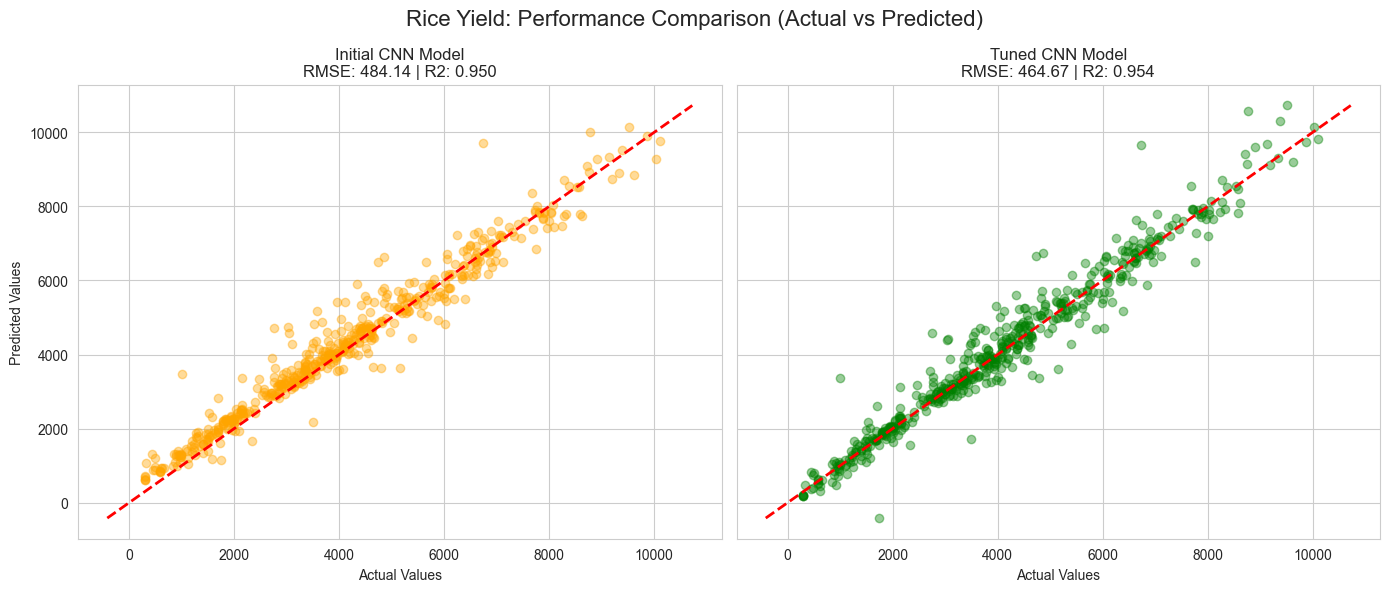

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate Improvement % (Comparing Tuned vs Initial)
imp_final = (rmse_test_init - rmse_test_final) / rmse_test_init * 100

print("--- Final Performance Report (Test Set) ---")
print(f"Initial Model:  RMSE={rmse_test_init:.2f}, R2={r2_test_init:.4f}")
print(f"Tuned CNN Model: RMSE={rmse_test_final:.2f}, R2={r2_test_final:.4f} (RMSE Improved {imp_final:.2f}%)")

# --- PLOTTING RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Axis Limits
all_preds = np.concatenate([y_pred_test_init, y_pred_test_final])
all_true = np.concatenate([y_test, y_test])
min_val, max_val = min(min(all_preds), min(all_true)), max(max(all_preds), max(all_true))

# 1. Initial Model Plot
axes[0].scatter(y_test, y_pred_test_init, alpha=0.4, color='orange')
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[0].set_title(f'Initial CNN Model\nRMSE: {rmse_test_init:.2f} | R2: {r2_test_init:.3f}')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')

# 2. Tuned Model Plot
axes[1].scatter(y_test, y_pred_test_final, alpha=0.4, color='green')
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
axes[1].set_title(f'Tuned CNN Model\nRMSE: {rmse_test_final:.2f} | R2: {r2_test_final:.3f}')
axes[1].set_xlabel('Actual Values')

plt.suptitle(f'{CHOSEN_CROP.capitalize()} Yield: Performance Comparison (Actual vs Predicted)', fontsize=16)
plt.tight_layout()
plt.show()


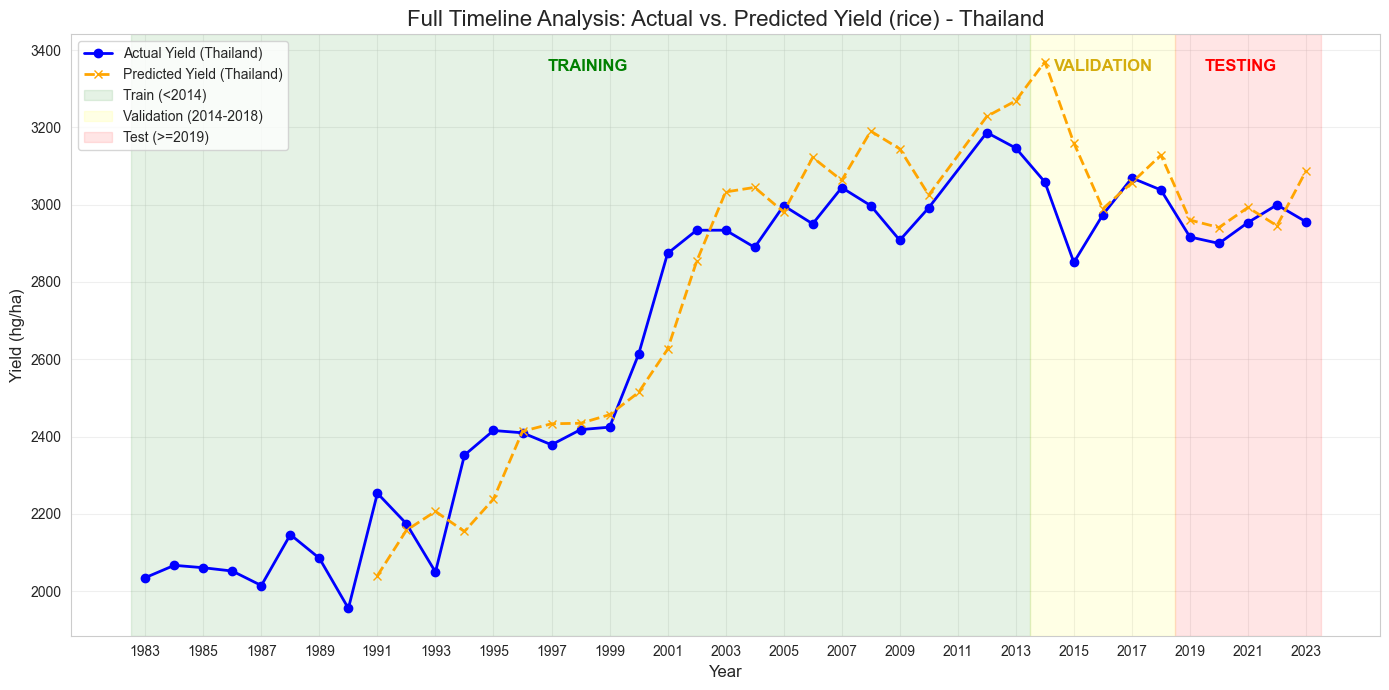

In [9]:
# --- FULL TIMELINE PLOT (THAILAND ONLY) ---
import matplotlib.pyplot as plt

# 1. Generate Predictions for all data
# Using the scaler and model already fit/loaded
X_all_scaled = scaler.transform(df_model[feature_cols])
# Reshape for CNN [Samples, 1, Features]
X_all_cnn = X_all_scaled.reshape(X_all_scaled.shape[0], 1, X_all_scaled.shape[1])
X_all_tensor = torch.tensor(X_all_cnn, dtype=torch.float32).to(device)

final_model.eval()
with torch.no_grad():
    all_predictions = final_model(X_all_tensor).cpu().numpy().flatten()

# 2. Create DataFrame with 'Area' included
df_full_trend = pd.DataFrame({
    'Year': df_model['year'],
    'Area': df_model['area'], # Added Area column for filtering
    'Actual': df_model[TARGET_COL],
    'Predicted': all_predictions
})

# 3. Filter for Thailand Only
TARGET_COUNTRY = 'Thailand'
country_trend = df_full_trend[df_full_trend['Area'] == TARGET_COUNTRY].sort_values('Year')

# Check if data exists for the country
if country_trend.empty:
    print(f"No data found for {TARGET_COUNTRY}. Please check the spelling or choose another country.")
else:
    # 4. Plotting
    plt.figure(figsize=(14, 7))

    # Plot Lines for specific country
    plt.plot(country_trend['Year'], country_trend['Actual'], 
             marker='o', label=f'Actual Yield ({TARGET_COUNTRY})', linewidth=2, color='blue')
    plt.plot(country_trend['Year'], country_trend['Predicted'], 
             marker='x', linestyle='--', label=f'Predicted Yield ({TARGET_COUNTRY})', linewidth=2, color='orange')

    # Define Split Boundaries based on the global config
    MIN_YEAR = country_trend['Year'].min()
    MAX_YEAR = country_trend['Year'].max()
    train_boundary = TRAIN_END_YEAR - 0.5
    val_boundary = VAL_END_YEAR - 0.5

    # --- Highlight Periods ---\
    # We use a try/except or safe bounds in case the country doesn't have data in all periods
    try:
        plt.axvspan(MIN_YEAR - 0.5, train_boundary, color='green', alpha=0.1, label=f'Train (<{TRAIN_END_YEAR})')
        plt.axvspan(train_boundary, val_boundary, color='yellow', alpha=0.1, label=f'Validation ({TRAIN_END_YEAR}-{VAL_END_YEAR - 1})')
        plt.axvspan(val_boundary, MAX_YEAR + 0.5, color='red', alpha=0.1, label=f'Test (>={VAL_END_YEAR})')
        
        # Add Text Labels
        y_max = country_trend['Actual'].max()
        text_y = y_max * 1.05 

        plt.text((MIN_YEAR + train_boundary)/2, text_y, 'TRAINING', ha='center', fontsize=12, fontweight='bold', color='green')
        plt.text((train_boundary + val_boundary)/2, text_y, 'VALIDATION', ha='center', fontsize=12, fontweight='bold', color='#D4AC0D')
        plt.text((val_boundary + MAX_YEAR)/2, text_y, 'TESTING', ha='center', fontsize=12, fontweight='bold', color='red')
    except:
        pass # Skip highlighting if year ranges don't align perfectly with this specific country's data

    # Final Formatting
    plt.title(f'Full Timeline Analysis: Actual vs. Predicted Yield ({CHOSEN_CROP}) - {TARGET_COUNTRY}', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Yield (hg/ha)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Ensure integer ticks for years
    plt.xticks(np.arange(int(MIN_YEAR), int(MAX_YEAR) + 1, 2))
    
    plt.tight_layout()
    plt.show()

* **Geographic Error:** We map the error rates by country to see where the model performs best and where it struggles.

In [10]:
# --- RE-CREATE COMPARISON DF WITH FEATURE JOINED ---
# We need the original 'area' column from the test set for joining
mask_test = df_model['year'] >= VAL_END_YEAR
test_set_context = df_model[mask_test][['area', 'year']] 

comparison_df = pd.DataFrame({
    'Actual_Value': y_test,
    'Predicted_Value': y_pred_test_final
})

# Join works automatically because y_test retained index from original df_model
comparison_df = comparison_df.join(test_set_context)
comparison_df = comparison_df[['year', 'area', 'Actual_Value', 'Predicted_Value']]

print("--- Actual vs. Predicted Test Set Results ---")
print(comparison_df.head())

--- Actual vs. Predicted Test Set Results ---
    year         area  Actual_Value  Predicted_Value
36  2019  Afghanistan        4476.6      4889.638672
37  2020  Afghanistan        4441.7      4823.091797
38  2021  Afghanistan        4406.5      4704.226562
39  2022  Afghanistan        4625.0      4779.298828
85  2019      Algeria        1788.9      1869.680664


In [11]:
import plotly.express as px

# Name Cleaning for Map Plotting
comparison_df['area'] = comparison_df['area'].replace({
    'United_States_of_America': 'United States',
    'United_Kingdom_of_Great_Britain_and_Northern_Ireland': 'United Kingdom',
    'Russian_Federation': 'Russia',
    'Viet_Nam': 'Vietnam',
    'Türkiye': 'Turkey',
    'Bolivia_(Plurinational_State_of)': 'Bolivia',
    'Iran_(Islamic_Republic_of)': 'Iran',
    "Lao_People's_Democratic_Republic": 'Laos',
    'China,_mainland': 'China',
    'China,_Taiwan_Province_of': 'Taiwan',
    "Democratic_People's_Republic_of_Korea": 'North Korea',
    'Republic_of_Korea': 'South Korea',
    'Côte_d\'Ivoire': "Cote d'Ivoire",
    'United_Republic_of_Tanzania': 'Tanzania',
    'Micronesia_(Federated_States_of)': 'Micronesia',
    'Venezuela_(Bolivarian_Republic_of)': 'Venezuela'
})

def plot_geographic_error(comparison_df):
    # Squared Error (for RMSE)
    comparison_df['Squared_Error'] = (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) ** 2
    # Squared Percentage Error (for RMSPE)
    epsilon = 1e-6 
    comparison_df['Squared_Percentage_Error'] = (
        (comparison_df['Actual_Value'] - comparison_df['Predicted_Value']) / 
        (comparison_df['Actual_Value'] + epsilon)
    ) ** 2

    # Aggregate Errors by Country
    rmse_df = (
        comparison_df.groupby('area')['Squared_Error']
        .mean().apply(np.sqrt).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Error': 'RMSE'})
    )
    rmspe_df = (
        comparison_df.groupby('area')['Squared_Percentage_Error']
        .mean().apply(np.sqrt).multiply(100).reset_index()
        .rename(columns={'area': 'Country', 'Squared_Percentage_Error': 'RMSPE'})
    )
    ap_df = comparison_df.groupby('area')[['Actual_Value', 'Predicted_Value']].mean().reset_index()
    ap_df = ap_df.rename(columns={'area': 'Country'})

    # Merge stats
    error_stats = rmspe_df.merge(rmse_df, on='Country', how='left')
    error_stats = error_stats.merge(ap_df, on='Country', how='left') 

    # Plot
    fig = px.choropleth(
        error_stats,
        locations='Country',
        color='RMSPE',
        locationmode='country names',
        color_continuous_scale=['green', 'red'], 
        range_color=[0, 50], 
        title='Geographic Distribution of Prediction Error (RMSPE) - 1D CNN',
        labels={'RMSPE': 'RMSPE (%)'},
        hover_name='Country',
        hover_data={'RMSPE': ':.2f', 'RMSE': ':.2f', 'Actual_Value': ':.2f', 'Predicted_Value': ':.2f'},
        projection='natural earth'
    )
    fig.update_layout(
        title_font_size=18,
        coloraxis_colorbar=dict(title='RMSPE (%)', orientation='h', len=0.5, yanchor='bottom', y=-0.12),
        geo=dict(showframe=False, showcoastlines=True, showcountries=True, countrycolor='black', bgcolor='lightgrey')
    )
    fig.show()

plot_geographic_error(comparison_df)

/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_5475/527999851.py:52: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



### 9. Key Factors (Feature Importance)
1D-CNNs, like basic Neural Networks, don't have built-in feature importance. We calculate **Permutation Importance** by shuffling each feature column one at a time and measuring the error increase. Since the CNN requires 3D input, we create a wrapper to handle the reshaping automatically during the permutation process.


--- Top 20 Most Important Features (Permutation Importance) ---
              Feature   Importance
0   avg_yield_rice_1y  1160.305512
1   avg_yield_rice_2y  1121.545876
2   avg_yield_rice_3y   299.235017
3        solar_annual    58.175478
4            rain_sin    50.886037
5            temp_sin    45.770885
6         temp_annual    39.483982
7            temp_cos    36.288544
8           solar_cos    30.401077
9            rain_cos    27.290683
10        rain_annual    24.973222
11          solar_sin    24.646142
12    pesticides_lag1    21.406433
13          longitude    18.537982
14    fertilizer_lag1    15.779010
15           latitude    13.397662
16               year     1.049364


/var/folders/zn/lrmslqwn0g3_slr732tvb0zw0000gn/T/ipykernel_5475/3682473412.py:42: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




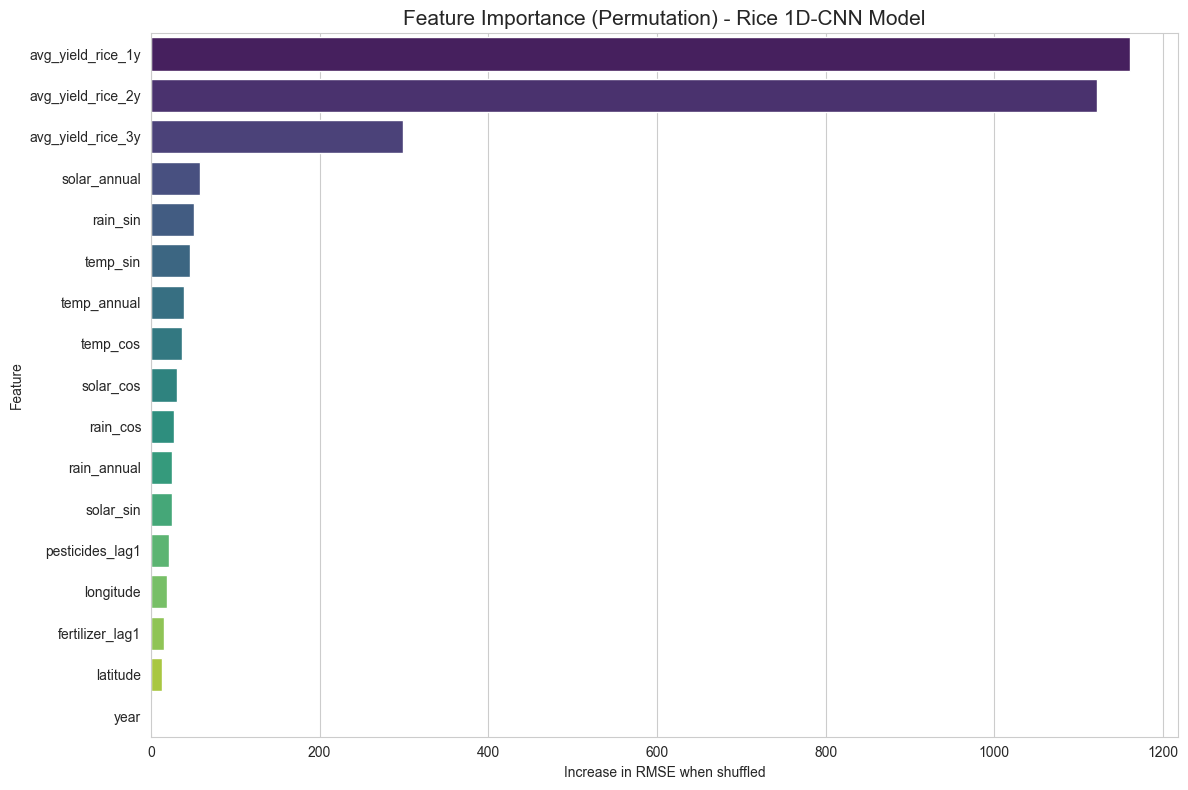

In [12]:
# --- WRAPPER FOR SKLEARN COMPATIBILITY (Reshaping logic added) ---
class PyTorchEstimator:
    """Wrapper to make PyTorch model behave like a Sklearn estimator for permutation_importance"""
    def __init__(self, model, device):
        self.model = model
        self.device = device

    def fit(self, X, y):
        pass # Model is already trained

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            # Reshape X from [Batch, Features] to [Batch, 1, Features] for CNN
            X_reshaped = X.reshape(X.shape[0], 1, X.shape[1])
            X_tensor = torch.tensor(X_reshaped, dtype=torch.float32).to(self.device)
            preds = self.model(X_tensor).cpu().numpy().flatten()
        return preds

# --- CALCULATE PERMUTATION IMPORTANCE ---
# Using validation set to gauge importance generalization
wrapped_model = PyTorchEstimator(final_model, device)
# X_val is the 2D array, the wrapper handles reshaping to 3D
results = permutation_importance(wrapped_model, X_val, y_val, scoring='neg_root_mean_squared_error', n_repeats=5, random_state=42)

# --- PROCESS RESULTS ---
importance_means = np.abs(results.importances_mean)
feature_names = np.array(feature_cols)

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_means
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print Top 20
print("\n--- Top 20 Most Important Features (Permutation Importance) ---")
print(fi_df.head(20))

# --- PLOT ---
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title(f'Feature Importance (Permutation) - {CHOSEN_CROP.capitalize()} 1D-CNN Model', fontsize=15)
plt.xlabel('Increase in RMSE when shuffled')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()